# Unsupervised NLP using Medical Transcription Data

Data Source: mtsamples.com

In [1]:
import pandas as pd
import numpy as np
import scipy

import spacy
import nltk
import re

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

np.random.seed(27)

In [2]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22})

sns.set_palette('bright')
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=0.8)

In [3]:
raw_data = pd.read_csv('mtsamples.csv')
raw_data.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


## Data Cleaning / Text Pre-Processing

In [4]:
df = raw_data.copy()
df = df.drop(df.columns[0], axis=1)
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
df.iloc[4, 3]

'1.  The left ventricular cavity size and wall thickness appear normal.  The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%.  There is near-cavity obliteration seen.  There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function.  There is abnormal left ventricular relaxation pattern seen as well as elevated left atrial pressures seen by Doppler examination.,2.  The left atrium appears mildly dilated.,3.  The right atrium and right ventricle appear normal.,4.  The aortic root appears normal.,5.  The aortic valve appears calcified with mild aortic valve stenosis, calculated aortic valve area is 1.3 cm square with a maximum instantaneous gradient of 34 and a mean gradient of 19 mm.,6.  There is mitral annular calcification extending to leaflets and supportive structures with thickening of mitral valve leaflets with mi

In [6]:
#checking for missing values

# from https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb# from  
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values_table(df)

Your selected dataframe has 5 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
keywords,1068,21.4
transcription,33,0.7


In [7]:
# dropping missing values
df = df.dropna()

In [8]:
# checking how many specialties we have
df.medical_specialty.value_counts()

 Surgery                          1021
 Orthopedic                        303
 Cardiovascular / Pulmonary        280
 Radiology                         251
 Consult - History and Phy.        234
 Gastroenterology                  195
 Neurology                         168
 General Medicine                  146
 SOAP / Chart / Progress Notes     142
 Urology                           140
 Obstetrics / Gynecology           130
 ENT - Otolaryngology               84
 Neurosurgery                       81
 Ophthalmology                      79
 Discharge Summary                  77
 Nephrology                         63
 Hematology - Oncology              62
 Pain Management                    58
 Office Notes                       44
 Podiatry                           42
 Pediatrics - Neonatal              42
 Emergency Room Reports             31
 Dentistry                          25
 Dermatology                        25
 Cosmetic / Plastic Surgery         25
 Letters                 

In [9]:
# process transcription texts
## source: https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # visual inspection shows a lot of dashes between words
    # I don't want the words to run together so replacing with spaces before stripping special characters
    doc = doc.replace('-', ' ')
    # lowercase and remove all nonalphanumeric characters
    doc = re.sub(r'([^\s\w]|_)+', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter out stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [10]:
norm_df = df.copy()

norm_df['medical_specialty'] = normalize_corpus(df.medical_specialty)
norm_df['transcription'] = normalize_corpus(df.transcription)
norm_df['description'] = normalize_corpus(df.description)

norm_df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,23 year old white female presents complaint al...,allergy immunology,Allergic Rhinitis,subjective 23 year old white female presents c...,"allergy / immunology, allergic rhinitis, aller..."
1,consult laparoscopic gastric bypass,bariatrics,Laparoscopic Gastric Bypass Consult - 2,past medical history difficulty climbing stair...,"bariatrics, laparoscopic gastric bypass, weigh..."
2,consult laparoscopic gastric bypass,bariatrics,Laparoscopic Gastric Bypass Consult - 1,history present illness seen abc today pleasan...,"bariatrics, laparoscopic gastric bypass, heart..."
3,2 mode doppler,cardiovascular pulmonary,2-D Echocardiogram - 1,2 mode 1 left atrial enlargement left atrial d...,"cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2 echocardiogram,cardiovascular pulmonary,2-D Echocardiogram - 2,1 left ventricular cavity size wall thickness ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [11]:
# lemmatizing transcription text
nlp = spacy.load('en')

# source: https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch07_Analyzing_Movie_Reviews_Sentiment/Text%20Normalization%20Demo.ipynb

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [12]:
norm_df['lemma_transcription'] = [lemmatize_text(item) for item in norm_df.transcription]

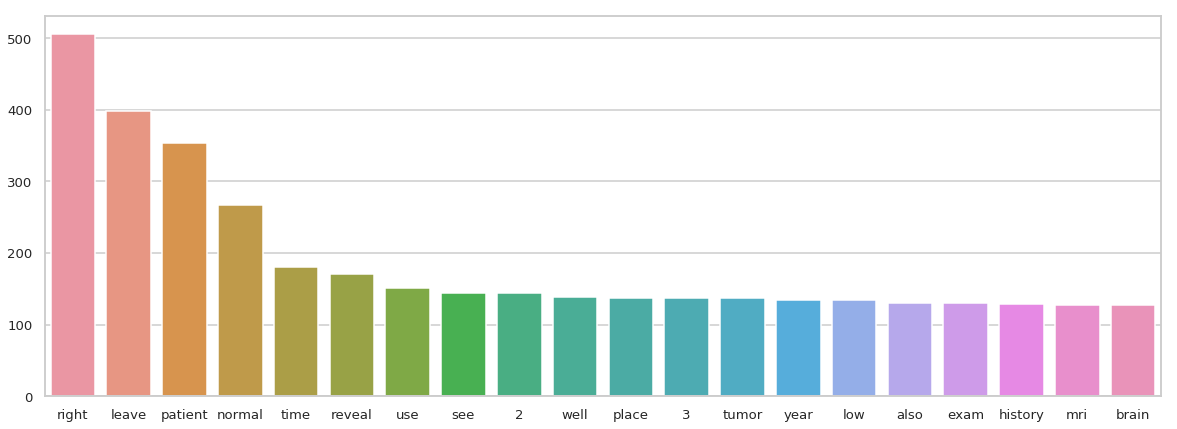

In [13]:
# Let's visualize some common words
# Grab all text associated with Neurology
neurology_text = [text for text in norm_df[norm_df['medical_specialty'] == 'neurology']['lemma_transcription']]
neurology_text = ' '.join(neurology_text).split()
neurology_counts = Counter(neurology_text)


neurology_common_words = [word[0] for word in neurology_counts.most_common(20)]
neurology_common_counts = [word[1] for word in neurology_counts.most_common(20)]
sns.barplot(neurology_common_words, neurology_common_counts);

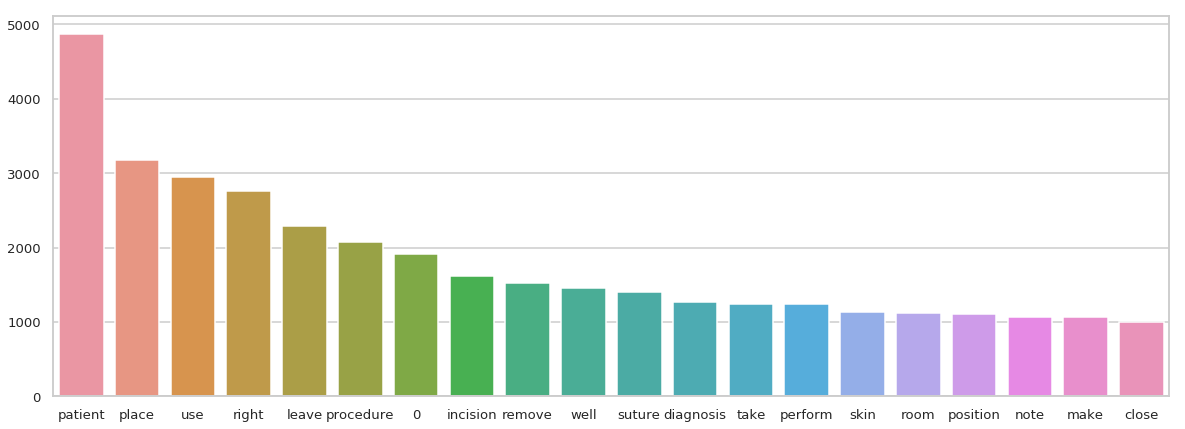

In [14]:
surgery_text = [text for text in norm_df[norm_df['medical_specialty'] == 'surgery']['lemma_transcription']]
surgery_text = ' '.join(surgery_text).split()
surgery_counts = Counter(surgery_text)


surgery_common_words = [word[0] for word in surgery_counts.most_common(20)]
surgery_common_counts = [word[1] for word in surgery_counts.most_common(20)]

plt.rcParams["axes.labelsize"] = 8
sns.barplot(surgery_common_words, surgery_common_counts);

## Bag of Words

In [15]:
cv = CountVectorizer()
cv_matrix = cv.fit_transform(norm_df.transcription).toarray()
cv_matrix

array([[0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [16]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
transcription_bow = pd.DataFrame(cv_matrix, columns=vocab)
transcription_bow.head()

,00,000,0000000dear,0004,001,0013,0014,0018,001past,0025,...,zthe,zuba,zumi,zygoma,zygomatic,zymar,zyprexa,zyrtec,zyvox,µiuml
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Fit Supervised Learning Model
Using our bag of words features let's see how a model performs using random forest in predicting medical specialty.

In [17]:
rfc = ensemble.RandomForestClassifier()
y = norm_df['medical_specialty']
X = transcription_bow

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.5654265554842848

Test set score: 0.08846153846153847


We definitely have some work to do increase accuracy.  Let's try using some other nlp techniques like TF-IDF and dimension reduction.

## TF-IDF Vectorizer

In [18]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(norm_df['transcription'])
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
transcription_tv = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
transcription_tv.head()

,00,000,0000000dear,0004,001,0013,0014,0018,001past,0025,...,zthe,zuba,zumi,zygoma,zygomatic,zymar,zyprexa,zyrtec,zyvox,µiuml
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.19,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


## Fit Supervised Learning Model
Using our tf-idf features let's see if this model performs any better than our bag of words.

In [19]:
rfc = ensemble.RandomForestClassifier()
y = norm_df['medical_specialty']
X = transcription_tv

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.5695958948043618

Test set score: 0.07948717948717948


TF-IDF is definitely performing much better than bag of words.  Let's try some other models to see if we can find a better one.

## TF-IDF with Logistic Regression

In [20]:
lr = LogisticRegression()
train = lr.fit(X_train, y_train)

print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

Training set score: 0.4964720974983964

Test set score: 0.2782051282051282


Random Forest definitely performs better than Logistic Regression here.  Let's try one more technique.

## TF-IDF with Gradient Boosting

In [21]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.5708787684413086

Test set score: 0.08205128205128205


Gradient boosting didn't peform so well.  It looks like random forest is our best model.

## Increase Accuracy
Let's try using LSA to see if we can increase accuracy on our TF-IDF model.

In [36]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space 
svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))

# fit the data
X_lsa = lsa.fit_transform(X)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 82.86434939735088


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_lsa, 
                                                    y,
                                                    test_size=0.2)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.563181526619628

Test set score: 0.07179487179487179


That didn't do much to increase our accuracy.  Let's try further reducing the dimensionality to see what happens.

In [39]:
#Our SVD data reducer.  We are going to reduce the feature space 
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))

# fit the data
X_lsa = lsa.fit_transform(X_lsa)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 33.58364430009454


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_lsa, 
                                                    y,
                                                    test_size=0.2)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.5702373316228352

Test set score: 0.08846153846153847


It appears further dimensionality reduction increased our accuracy, but I'm concerned that this model captures only 33% of the variance.